In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve,plot_precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score

###  <font color='navy'>Data Exploration </font>

In [2]:
#read training and test datasets
airlines_train = pd.read_csv('airlines_train.csv')
airlines_test = pd.read_csv('airlines_test.csv')

In [3]:
#dimensions training dataset
airlines_train.shape

(103904, 25)

In [4]:
#dimensions of test dataset
airlines_test.shape

(25976, 25)

In [5]:
#concat both datasets together
airlines = pd.concat([airlines_train, airlines_test], axis=0)

In [6]:
#dimension of combined dataset
airlines.shape

(129880, 25)

In [7]:
# inspect the dataset
airlines.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
# print a concise summary
airlines.info()
#arrival in minutes col has missing values. if the flight is early or on-time then delay is missing. this needs to be corrected in preprocessing

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
Unnamed: 0                           129880 non-null int64
id                                   129880 non-null int64
Gender                               129880 non-null object
Customer Type                        129880 non-null object
Age                                  129880 non-null int64
Type of Travel                       129880 non-null object
Class                                129880 non-null object
Flight Distance                      129880 non-null int64
Inflight wifi service                129880 non-null int64
Departure/Arrival time convenient    129880 non-null int64
Ease of Online booking               129880 non-null int64
Gate location                        129880 non-null int64
Food and drink                       129880 non-null int64
Online boarding                      129880 non-null int64
Seat comfort                         129880 non-null int64
I

In [9]:
# target varaible is satisfaction
airlines.satisfaction.value_counts()

neutral or dissatisfied    73452
satisfied                  56428
Name: satisfaction, dtype: int64

In [10]:
# as a percentage
airlines.satisfaction.value_counts(normalize=True)
# roughly a balaced dataset

neutral or dissatisfied    0.565537
satisfied                  0.434463
Name: satisfaction, dtype: float64

In [11]:
# training and test sets are splits in a stratifed fasion
airlines_test.satisfaction.value_counts(normalize=True)

neutral or dissatisfied    0.561018
satisfied                  0.438982
Name: satisfaction, dtype: float64

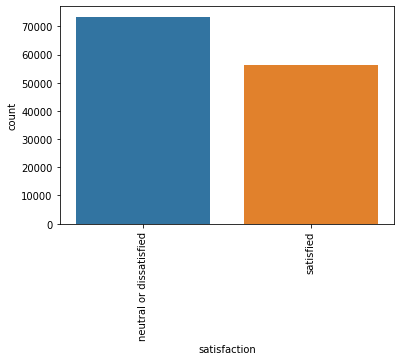

In [12]:
# plot satisfied vs neutral/not satisfied
s = sns.countplot(x='satisfaction', data=airlines)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

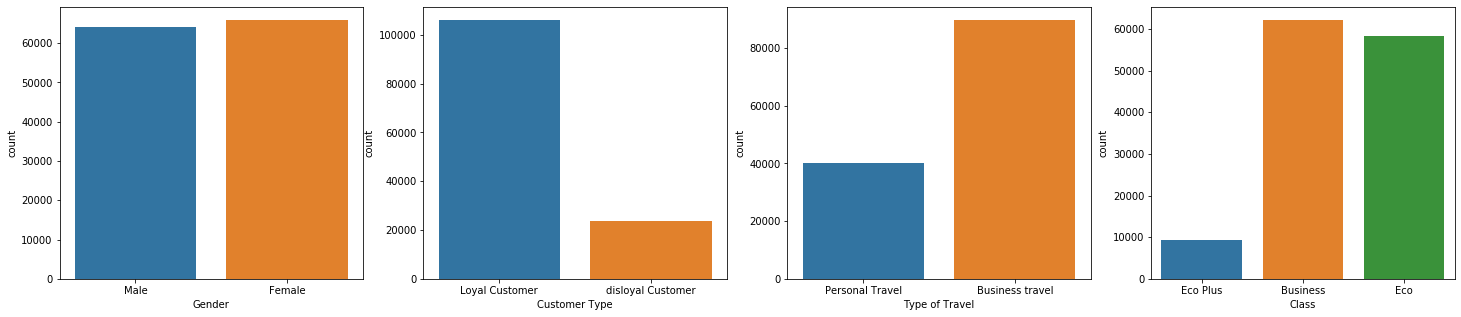

In [13]:
# plotting the frequencies of categorical variables: Gender , Cust Type, Type of Travel, Class
f, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.countplot(x='Gender', data=airlines, ax=ax[0])
sns.countplot(x='Customer Type', data=airlines, ax=ax[1])
sns.countplot(x='Type of Travel', data=airlines, ax=ax[2])
sns.countplot(x='Class', data=airlines, ax=ax[3])
plt.show()

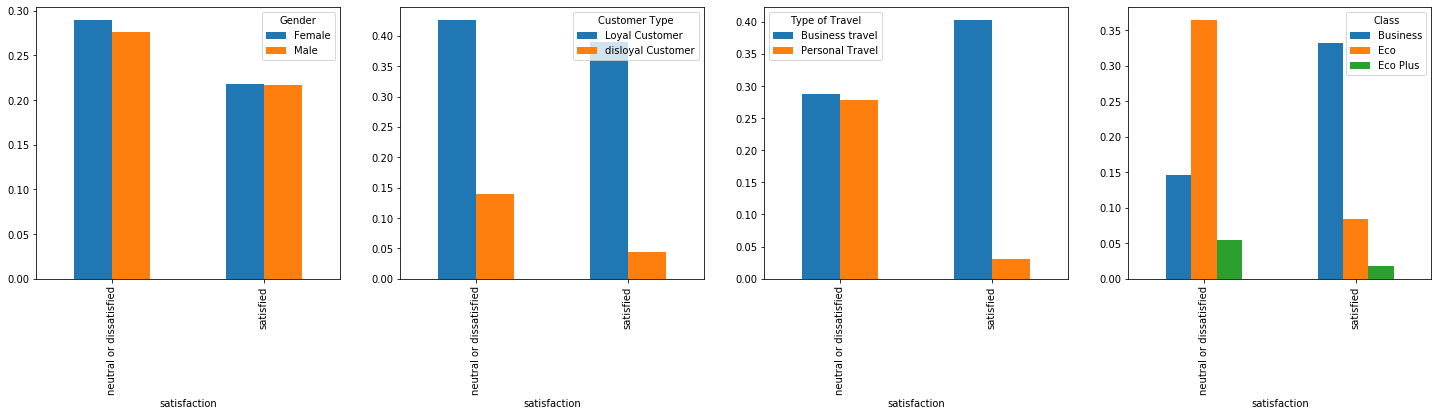

In [14]:
# plotting the frequencies of categorical variables vs target
f, ax = plt.subplots(1, 4, figsize=(25, 5))
pd.crosstab(airlines['satisfaction'], airlines['Gender'], normalize=True).plot(kind='bar', ax=ax[0])
pd.crosstab(airlines['satisfaction'], airlines['Customer Type'], normalize=True).plot(kind='bar', ax=ax[1])
pd.crosstab(airlines['satisfaction'], airlines['Type of Travel'], normalize=True).plot(kind='bar', ax=ax[2])
pd.crosstab(airlines['satisfaction'], airlines['Class'], normalize=True).plot(kind='bar', ax=ax[3])
plt.show()

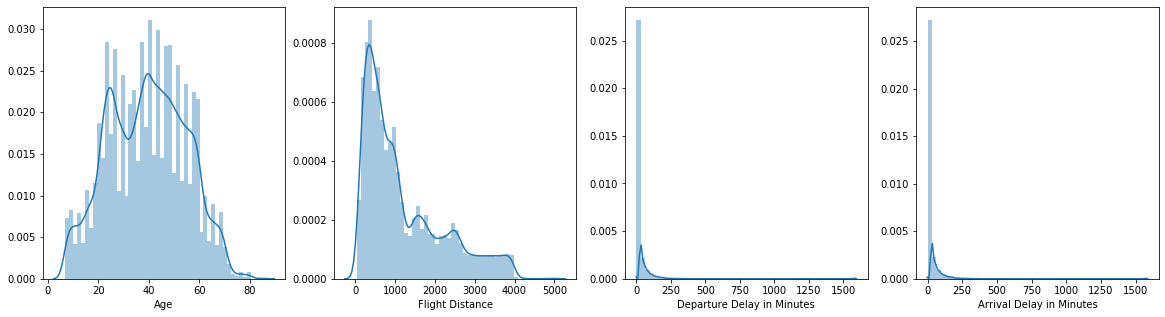

In [15]:
# Plotting (hist and kde) continous variables Age, flight distance, depature and arrival delay
f, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(airlines['Age'], ax=ax[0])
sns.distplot(airlines['Flight Distance'], ax=ax[1])
sns.distplot(airlines['Departure Delay in Minutes'] , ax=ax[2])
sns.distplot(airlines['Arrival Delay in Minutes'].fillna(0) , ax=ax[3])
plt.show()

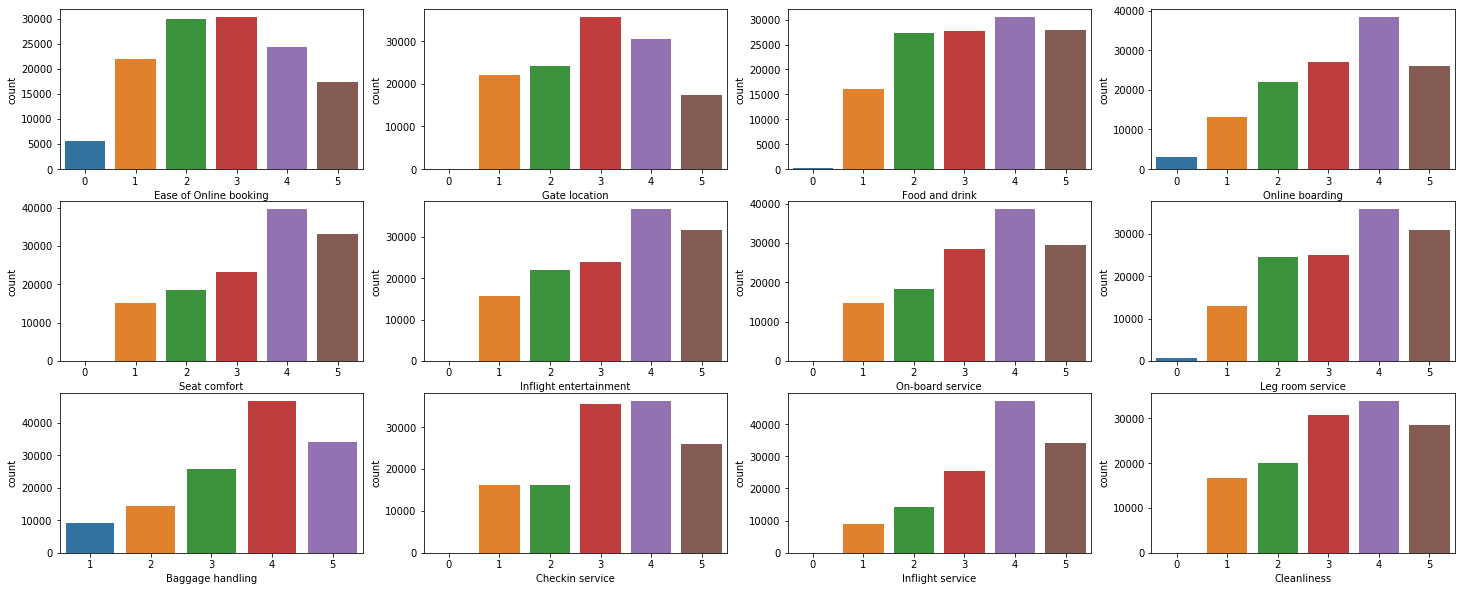

In [16]:
# Plotting the remaining columns are ordinal variables 
f, ax = plt.subplots(3, 4, figsize=(25, 10))
sns.countplot(x='Ease of Online booking', data=airlines, ax=ax[0,0])
sns.countplot(x='Gate location', data=airlines, ax=ax[0,1])
sns.countplot(x='Food and drink', data=airlines, ax=ax[0,2])
sns.countplot(x='Online boarding', data=airlines, ax=ax[0,3])
sns.countplot(x='Seat comfort', data=airlines, ax=ax[1,0])
sns.countplot(x='Inflight entertainment', data=airlines, ax=ax[1,1])
sns.countplot(x='On-board service', data=airlines, ax=ax[1,2])
sns.countplot(x='Leg room service', data=airlines, ax=ax[1,3])
sns.countplot(x='Baggage handling', data=airlines, ax=ax[2,0])
sns.countplot(x='Checkin service', data=airlines, ax=ax[2,1])
sns.countplot(x='Inflight service', data=airlines, ax=ax[2,2])
sns.countplot(x='Cleanliness', data=airlines, ax=ax[2,3])
plt.show()

###  <font color='navy'>Data Preprocessing </font>

In [17]:
# if the flight is early or on-time the arrival delay must be zero 
airlines['Arrival Delay in Minutes'] = airlines['Arrival Delay in Minutes'].fillna(0)

In [18]:
# binarize taget variavle
mapping = {'satisfied':1, 'neutral or dissatisfied':0}
airlines['satisfaction'] = airlines['satisfaction'].map(mapping)

In [19]:
#ecode categorical variables
airlines = pd.get_dummies(airlines, columns=['Gender','Customer Type', 'Type of Travel', 'Class'])

In [20]:
airlines.columns

Index(['Unnamed: 0', 'id', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'Gender_Female', 'Gender_Male',
       'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'Class_Business', 'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

In [21]:
# dummy encoding. 
cat_to_drop = ['Gender_Female', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel', 'Class_Eco Plus']
airlines.drop(cat_to_drop, axis=1, inplace=True)

In [22]:
# Prepare data for machine learning columns to drop 
col_to_drop = ['Unnamed: 0', 'id',  'satisfaction']
X = airlines.drop(col_to_drop, axis=1)
y = airlines.satisfaction.values

In [23]:
X.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Gender_Male', 'Customer Type_Loyal Customer',
       'Type of Travel_Business travel', 'Class_Business', 'Class_Eco'],
      dtype='object')

###  <font color='navy'>Train and Compare Classifiers</font>

In [24]:
# train and test data
train_size = len(airlines_train)
X_train = X.iloc[0:train_size, :]
X_test = X.iloc[train_size: , :]
y_train = y[:train_size]
y_test = y[train_size:]

In [25]:
#set seed for reproducibility
SEED = 1411

In [26]:
#isntantiate the classifiers
clf_rf = RandomForestClassifier(random_state=1411)
clf_ab = AdaBoostClassifier(random_state=1411)
clf_gb = GradientBoostingClassifier(random_state=1411)

In [27]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest', 'Ada Boost', 'Gradient Boost']

# create a list of classifiers
classifiers = [clf_rf, clf_ab, clf_gb]

In [28]:
# Metrics of interest 
meancv_scores_list = []
accuracy_list = []
precision_list=[]
recall_list =[]
f1score_list=[]
kappa_list =[]

In [29]:
# for each classifier in the classifier above do the following
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    meancv_scores_list.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test)
    
    # calculate and append the metrics of interest
    accuracy_list.append(accuracy_score(y_test, y_pred)) 
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1score_list.append(f1_score(y_test, y_pred))
    kappa_list.append(cohen_kappa_score(y_test, y_pred))

In [44]:
#create a summary dataframe  
df_summary = pd.DataFrame(list(zip(names, meancv_scores_list,accuracy_list,precision_list,recall_list,f1score_list,kappa_list)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )
df_summary.round(3)

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.962,0.963,0.972,0.942,0.957,0.924
1,Ada Boost,0.928,0.929,0.925,0.911,0.918,0.855
2,Gradient Boost,0.942,0.941,0.945,0.920,0.932,0.881


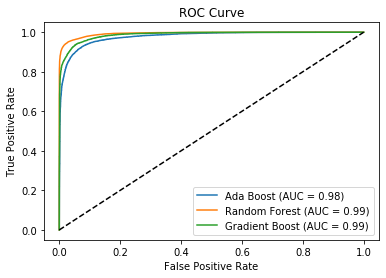

In [31]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(clf_ab, X_test, y_test, name='Ada Boost', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(clf_rf, X_test, y_test, name='Random Forest', ax=ax)
plot_roc_curve(clf_gb, X_test, y_test, name='Gradient Boost', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

*Random Forest appears to have the highest Accuracy (both CV and test set), Precision, Recall, F1 Score and Area under ROC out of the three ensemble classifiers.*

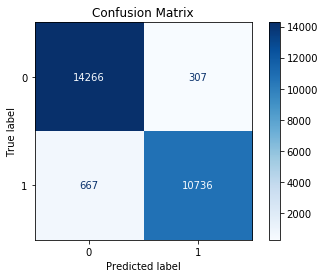

In [32]:
#plot_confusion_matrix
plot_confusion_matrix(clf_rf, X_test, y_test,cmap=plt.cm.Blues) 
plt.title('Confusion Matrix')
plt.show()

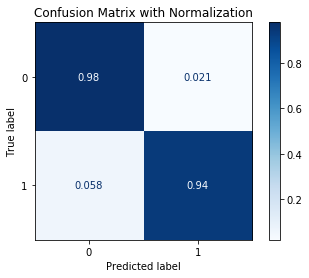

In [33]:
# plot confusion matrix normalized
plot_confusion_matrix(clf_rf, X_test, y_test,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix with Normalization')
plt.show()

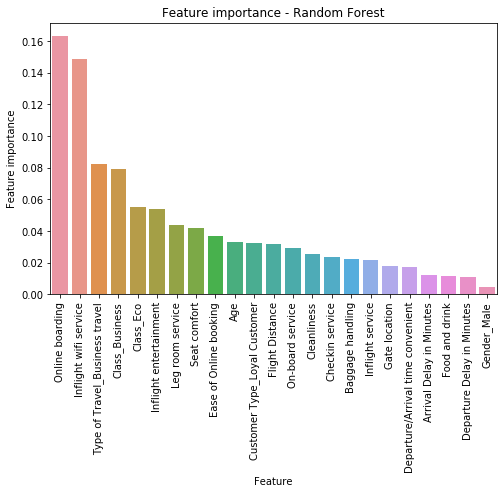

In [34]:
#plot Feature Importance
df_features_rf = pd.DataFrame({'Feature': X.columns, 'Feature importance': clf_rf.feature_importances_})
df_features_rf = df_features_rf.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (8,5))
plt.title('Feature importance - Random Forest')
s=sns.barplot(x='Feature',y='Feature importance',data=df_features_rf)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

#### Appendix 1 : Can Gradient Boost or Ada Boost Classifiers do better if the forest size is increased?

In [35]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest', 'Ada Boost', 'Gradient Boost']

# create a list of classifiers
classifiers = [clf_rf, clf_ab, clf_gb]

In [36]:
# Metrics of interest 
accuracy_list = []
precision_list=[]
recall_list =[]
f1score_list=[]
kappa_list =[]

In [37]:
# number of trees
forest_size = [100,250,500,750,1000,1500]
tree_sizes = []

In [38]:
import itertools
names_list = [y+' '+str(x) for x, y in list(itertools.product(forest_size,names))]
names_list

['Random Forest 100',
 'Ada Boost 100',
 'Gradient Boost 100',
 'Random Forest 250',
 'Ada Boost 250',
 'Gradient Boost 250',
 'Random Forest 500',
 'Ada Boost 500',
 'Gradient Boost 500',
 'Random Forest 750',
 'Ada Boost 750',
 'Gradient Boost 750',
 'Random Forest 1000',
 'Ada Boost 1000',
 'Gradient Boost 1000',
 'Random Forest 1500',
 'Ada Boost 1500',
 'Gradient Boost 1500']

In [39]:
# for each classifier in the classifier above do the following
for num_trees in forest_size:
    for clf in classifiers:
        clf.n_estimators = num_trees

        # fit the classifier to the entire training set 
        clf.fit(X_train, y_train)
    
        # predict test values
        y_pred = clf.predict(X_test)
    
        # calculate and append the metrics of interest
        accuracy_list.append(accuracy_score(y_test, y_pred)) 
        precision_list.append(precision_score(y_test, y_pred))
        recall_list.append(recall_score(y_test, y_pred))
        f1score_list.append(f1_score(y_test, y_pred))
        kappa_list.append(cohen_kappa_score(y_test, y_pred))
        tree_sizes.append(num_trees)

In [46]:
#create a summary dataframe  
df_summary = pd.DataFrame(list(zip(names_list, accuracy_list,precision_list,recall_list,f1score_list,kappa_list, tree_sizes)),
                          columns=[ 'Classifier','Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa', 'No of Trees']
                         )
df_summary.round(3)

,Classifier,Accuracy,Precision,Recall,F1 Score,Kappa,No of Trees
0,Random Forest 100,0.963,0.972,0.942,0.957,0.924,100
1,Ada Boost 100,0.929,0.925,0.911,0.918,0.855,100
2,Gradient Boost 100,0.941,0.945,0.920,0.932,0.881,100
3,Random Forest 250,0.962,0.972,0.941,0.956,0.923,250
4,Ada Boost 250,0.930,0.926,0.913,0.920,0.858,250
5,Gradient Boost 250,0.956,0.963,0.936,0.949,0.911,250
6,Random Forest 500,0.962,0.972,0.941,0.957,0.924,500
7,Ada Boost 500,0.930,0.926,0.913,0.920,0.858,500
8,Gradient Boost 500,0.959,0.968,0.939,0.953,0.917,500
9,Random Forest 750,0.963,0.973,0.942,0.957,0.924,750


In [41]:
#separate the results for each classifer
df_rf = df_summary[df_summary['Classifier'].str.startswith('Random Forest')]
df_ab = df_summary[df_summary['Classifier'].str.startswith('Ada Boost')]
df_gb = df_summary[df_summary['Classifier'].str.startswith('Gradient Boost')]

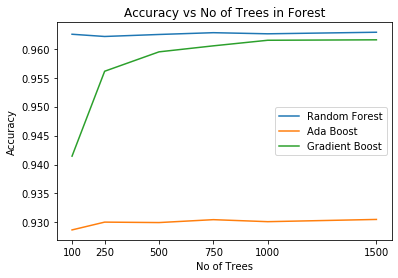

In [48]:
fig , ax = plt.subplots()
sns.lineplot(x="No of Trees", y="Accuracy", label='Random Forest', data=df_rf, ax=ax)
sns.lineplot(x="No of Trees", y="Accuracy", label='Ada Boost',data=df_ab, ax=ax)
sns.lineplot(x="No of Trees", y="Accuracy", label='Gradient Boost',data=df_gb, ax=ax)
ax.set_xticks(forest_size)
ax.set_title('Accuracy vs No of Trees in Forest')
ax.legend()
plt.show()

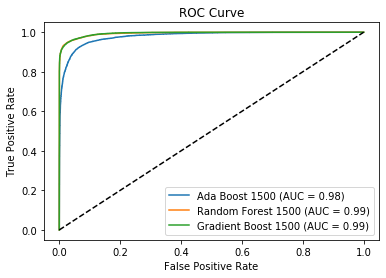

In [47]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(clf_ab, X_test, y_test, name='Ada Boost 1500', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(clf_rf, X_test, y_test, name='Random Forest 1500', ax=ax)
plot_roc_curve(clf_gb, X_test, y_test, name='Gradient Boost 1500', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

#### Data source & References